In [1]:
%pip install -U gymnasium
%pip install -U stable-baselines3
%pip install -U minigrid

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.core import ActionWrapper, ObservationWrapper, ObsType, Wrapper

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch
import torch.nn as nn

import minigrid
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from stable_baselines3 import PPO

import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv

In [3]:
from __future__ import annotations

import math
import operator
from functools import reduce
from typing import Any

import gymnasium as gym
import numpy as np
from gymnasium import logger, spaces
from gymnasium.core import ActionWrapper, ObservationWrapper, ObsType, Wrapper

from minigrid.core.constants import COLOR_TO_IDX, OBJECT_TO_IDX, STATE_TO_IDX
from minigrid.core.world_object import Goal


class FullyObsOneHotWrapper(ObservationWrapper):
    """
    """

    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(self.env.width * self.env.height * 11 + 4,),
            dtype=np.uint8,
        )
        # self.observation_space = spaces.Space((self.env.width * self.env.height + 4,))

    def observation(self, obs):
        num_classes = len(OBJECT_TO_IDX)
        env = self.env.unwrapped
        full_grid = env.grid.encode()[:, :, 0]
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = OBJECT_TO_IDX["agent"]
        full_grid = full_grid.flatten()
        full_grid = np.eye(num_classes)[full_grid].flatten()
        direction = np.eye(4)[env.agent_dir]

        obs = np.concatenate((direction, full_grid), axis=0)

        return obs

MiniGrid-LavaCrossingS9N1-v0
MiniGrid-LavaCrossingS9N2-v0
MiniGrid-LavaCrossingS9N3-v0
MiniGrid-LavaCrossingS11N5-v0


MiniGrid-SimpleCrossingS9N1-v0
MiniGrid-SimpleCrossingS9N2-v0
MiniGrid-SimpleCrossingS9N3-v0
MiniGrid-SimpleCrossingS11N5-v0

In [175]:
env = gym.make("MiniGrid-SimpleCrossingS9N2-v0", render_mode="rgb_array")
env = FullyObsOneHotWrapper(env)

/Users/jseely/miniconda3/envs/myenv2/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/Users/jseely/miniconda3/envs/myenv2/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


In [5]:
policy_kwargs = dict(net_arch=[1024, 1024])  # Two hidden layers with 128 neurons each

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    # batch_size=256,
    # ent_coef=0.015,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jseely/miniconda3/envs/myenv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model.learn(2e6)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 324      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 1247     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 322        |
|    ep_rew_mean          | 0.0139     |
| time/                   |            |
|    fps                  | 554        |
|    iterations           | 2          |
|    time_elapsed         | 7          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01475767 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.93      |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.0003     |
|   

In [176]:
obs, _ = env.reset()

ValueError: axes don't match array

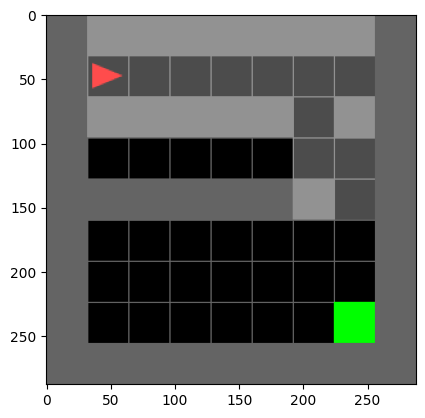

In [177]:
# Initialize variables for tracking rewards and steps
total_reward = 0
steps = 0

# Run one episode
# Render the environment (optional)
plt.imshow(env.render())

# Predict the action
action, _states = model.predict(obs, deterministic=False)
print(action), print(total_reward)

# Perform the action
obs, reward, done, _info, _ = env.step(action)

# Update total reward and steps
total_reward += reward
steps += 1

# CNN policy

In [505]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(
        self,
        observation_space: gym.Space,
        features_dim: int = 512,
        normalized_image: bool = False,
    ) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(64, 64, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(64, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [506]:
import minigrid
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO

policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = gym.make("MiniGrid-SimpleCrossingS9N2-v0", render_mode="rgb_array")
env = ImgObsWrapper(env)

model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [1126]:
model.learn(1e5, tb_log_name="./PPO", progress_bar=True)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 0.682    |
| time/              |          |
|    fps             | 1063     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 103         |
|    ep_rew_mean          | 0.702       |
| time/                   |             |
|    fps                  | 351         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.025969153 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.458      |
|    explained_variance   | 0.362       |
|    learning_rate        | 0.

In [1103]:
obs, _ = env.reset(seed=1)
# Initialize variables for tracking rewards and steps
total_reward = 0
steps = 0

2
0
0 False


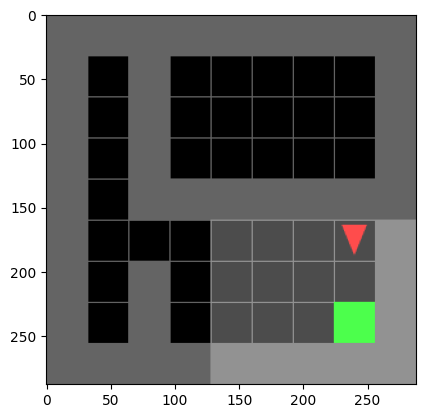

In [1121]:
# Run one episode
# Render the environment (optional)
plt.imshow(env.render())

# Predict the action
action, _states = model.predict(obs, deterministic=True)
print(action), print(total_reward)

# Perform the action
obs, reward, done, _info, _ = env.step(action)
print(reward, done)
# Update total reward and steps
total_reward += reward
steps += 1